# NIH CXR Database Image Classifier using VGG16 and Random Forrest

In [1]:
"""
Feature Extractor: NN pretained on ImageNet
Output layer(s): SVM - traditional machine learning classifiers
Inspired by Sreenivas Bhattiprolu's classifier of similar approach
https://github.com/bnsreenu/python_for_microscopists/blob/master/158_classification_CNN_RF.py
"""
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# import glob
import cv2
import tensorflow as tf
import keras
# from keras.models import Model, Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from sklearn import preprocessing, metrics
# from sklearn.ensemble import RandomForestClassifier

In [2]:
# SHOW US WHAT YAH GOT
import sys
print(f"GPU: {tf.config.list_physical_devices('GPU')}  ")
print(f"CPU: {tf.config.list_physical_devices('CPU')}  ")
print(f"Python {sys.version}\nTensorflow{tf.__version__}")

GPU: []  
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]  
Python 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:03:09) [Clang 13.0.1 ]
Tensorflow2.9.1


In [3]:
# define constansts
SIZE = 512  #Resize images, note original input shape for VGG is (224,244,3)
MAX_NUMBER_OF_EACH_FINDING = 200 #Total number of image for both testing and training
NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING = 20
df = pd.read_csv('Data_Entry_2017_v2020.csv')
PA_df = df[df['View Position'] == 'PA'] #Fileter just for PA view images (exclude AP)
filtered_df = PA_df[PA_df['Finding Labels'].str.fullmatch("No Finding|Fibrosis")]; # Filter for a selection of parenchymal diseases.  Ie Cardiomegally, pleural thickening, pneumothorax excluded.  Note consolidation & pneumonia also excluded (consolidation, infiltration, PNA are not all exclusive descriptive terms; PNAs can be very different in appearance - round PNA vs lobal PNA vs viral PNA); Did not include edema because there are only 51 studies from 10 unique patients
# filtered_df = filtered_df.drop_duplicates(subset=['Patient ID'],ignore_index=True)  #UNIQUE PATIENTS ONLY
print(f"NUMBER OF PA STUDIES WITH FINDING\n{ filtered_df['Finding Labels'].value_counts()}") 
total_df=filtered_df.groupby('Finding Labels').head(MAX_NUMBER_OF_EACH_FINDING) ### cut down the count of each type to a max number, some gropus may have less than the max (PA edema is a small group)
# print(pd.crosstab(df['View Position'],df['Finding Labels']).head(10));
test_df= filtered_df.groupby('Finding Labels').head(NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING).reset_index(drop=True)
train_df = total_df[~total_df['Image Index'].isin(test_df['Image Index'].to_list())]
# print(test_df)
# SANITY CHECK PRINTS
print(total_df.head()["Image Index"])
print(test_df.head()["Image Index"])
print(train_df.head()["Image Index"])

NUMBER OF PA STUDIES WITH FINDING
No Finding    39302
Fibrosis        648
Name: Finding Labels, dtype: int64
3     00000002_000.png
13    00000005_000.png
16    00000005_003.png
17    00000005_004.png
18    00000005_005.png
Name: Image Index, dtype: object
0    00000002_000.png
1    00000005_000.png
2    00000005_003.png
3    00000005_004.png
4    00000005_005.png
Name: Image Index, dtype: object
85     00000014_000.png
87     00000016_000.png
91     00000018_000.png
98     00000022_000.png
100    00000023_000.png
Name: Image Index, dtype: object


In [4]:
#define a function to the the images and their labels
def getImagesAndLabels(patients_df):
  labels = []
  images = []
  image_paths = patients_df['Image Index'].to_numpy()
  labels = patients_df['Finding Labels'].to_numpy()
  for img_path in image_paths:
    img_path = "dicom/NIH_images/"+img_path
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (SIZE, SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    images.append(img)

  return np.array(images), np.array(labels)
  #np.count_nonzero(Label_Array == 'No Finding')
  #Label_Array.size

In [5]:
train_images, train_labels = getImagesAndLabels(train_df)
test_images, test_labels = getImagesAndLabels(test_df)

In [6]:

train_labels[0:5],len(train_images),  len(test_images), test_labels[10:15]


(array(['No Finding', 'No Finding', 'No Finding', 'No Finding',
        'No Finding'], dtype=object),
 360,
 40,
 array(['No Finding', 'No Finding', 'No Finding', 'No Finding',
        'No Finding'], dtype=object))

In [7]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
test_labels_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
#Rename to standard naming conventions
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

##### RESCALE AND FORMAT DATA

In [9]:

# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [10]:
#One hot encode y values for neural network. 
y_train_one_hot = keras.utils.to_categorical(y_train)
y_test_one_hot = keras.utils.to_categorical(y_test)

In [11]:
# Sanity check
# x_train.max()

##### TRANSFER LEARNING  LOAD PRETRAINED KERAS APPLICATION

In [46]:
#Load model without output classifier/fully connected layers, set input shape to our custom SIZE 
IMAGE_SHAPE = (SIZE, SIZE)
print(IMAGE_SHAPE)
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False,  input_shape=(SIZE,SIZE,3), pooling='max')
base_model.trainable = False
inputs = keras.Input(shape=(SIZE, SIZE, 3))
# We make sure that the base_model is running in inference mode here
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
intermediate_outputs = base_model(inputs, training=False)
#base_model.summary()


(512, 512)


##### CREATE OUTPUT LAYERS AND ADD TO THE BASE MODEL

In [50]:
# CREATE A SVM (SUPPORT VECTOR MACHINE) FOR CLASSIFYING
# SVM example: https://github.com/krishnaik06/Complete-Deep-Learning/blob/master/Image%20Classification%20Using%20SVM.ipynb
# #FLATTEN - MAY NOT BE NEEDED WITH SOME BASE MODELS DEPENDING OUT OUTPUT SHAPE, COULD DO GLOBALMAXPOOLING INSTEAD
# x = keras.layers.Flatten()(x)
# # Make Fully Connection Layer
x = keras.layers.Dense(units=16, activation='relu')(intermediate_outputs)
# USE LINEAR CLASSIFICATION FOR A BINARY CLASSIFIER
outputs = keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='linear')(x) 
# # USE LINEAR CLASSIFICATION FOR A BINARY CLASSIFIER
# outputs = keras.layers.Dense(XXXXCATEGORYNUMBER, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(x) 
# CREATE OUR FINAL MODEL
model = keras.Model(inputs, outputs)

# #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
# for layer in model.layers:
# 	layer.trainable = False
model.summary()  #Trainable parameters will be 0

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_42 (Dense)            (None, 16)                32784     
                                                                 
 dense_43 (Dense)            (None, 1)                 17        
                                                                 
Total params: 21,835,585
Trainable params: 32,801
Non-trainable params: 21,802,784
_________________________________________________________________


In [53]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])
#Train the CNN model
history = model.fit(x_train, y_train_one_hot, epochs=2, validation_data = (x_test, y_test_one_hot), batch_size=8)



Epoch 1/2
17/45 [==========>...................] - ETA: 3:14 - loss: 1.0800 - accuracy: 0.5000

KeyboardInterrupt: 

##### EXTRACT FEATURES USING THE PRETRAINED CNN

In [13]:
#Send test data through same feature extractor process
X_test_feature = model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

2/2 [==============================] - 513s 212s/step


MAKE A RANDOM FOREST LAYER

In [14]:

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [15]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [16]:
#Print overall accuracy
accuracy = metrics.accuracy_score(test_labels, prediction_RF)
print ("Accuracy = ", accuracy)

Accuracy =  0.5


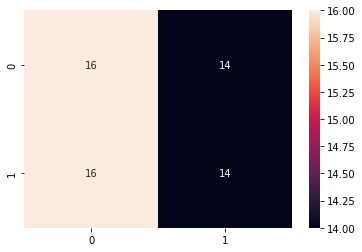

In [17]:
# from sklearn.metrics import confusion_matrix
#Confusion Matrix - verify accuracy of each class
cm = metrics.confusion_matrix(test_labels, prediction_RF)
#print(cm)
heatmap =sns.heatmap(cm, annot=True)

In [18]:
#UTILITY FUCTION FOR TIME STAMPS
import calendar
import time
from datetime import datetime

def getTimeStamp():
  # Current GMT time in a tuple format
  current_GMT = time.gmtime()

  # ts stores timestamp
  ts = calendar.timegm(current_GMT)
  date_time = datetime.fromtimestamp(ts)
  # convert timestamp to string in dd-mm-yyyy HH:MM:SS
  return date_time.strftime("%m%d-%H%M%S")


In [19]:

#Save confusion matrix
heatmap.get_figure().savefig(f"confusion_matrices/{getTimeStamp()}_VGG16-RF_cats{cm.shape[0]}-{MAX_NUMBER_OF_EACH_FINDING}-{NUMBER_OF_EACH_FINDING_RESERVED_FOR_TESTING}_size{SIZE}_acc{round(accuracy,2)}.png")

1/1 [==============================] - 4s 4s/step
The prediction for this image is:  ['No Finding']
The actual label for this image is:  Fibrosis


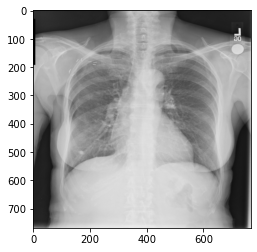

In [20]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])